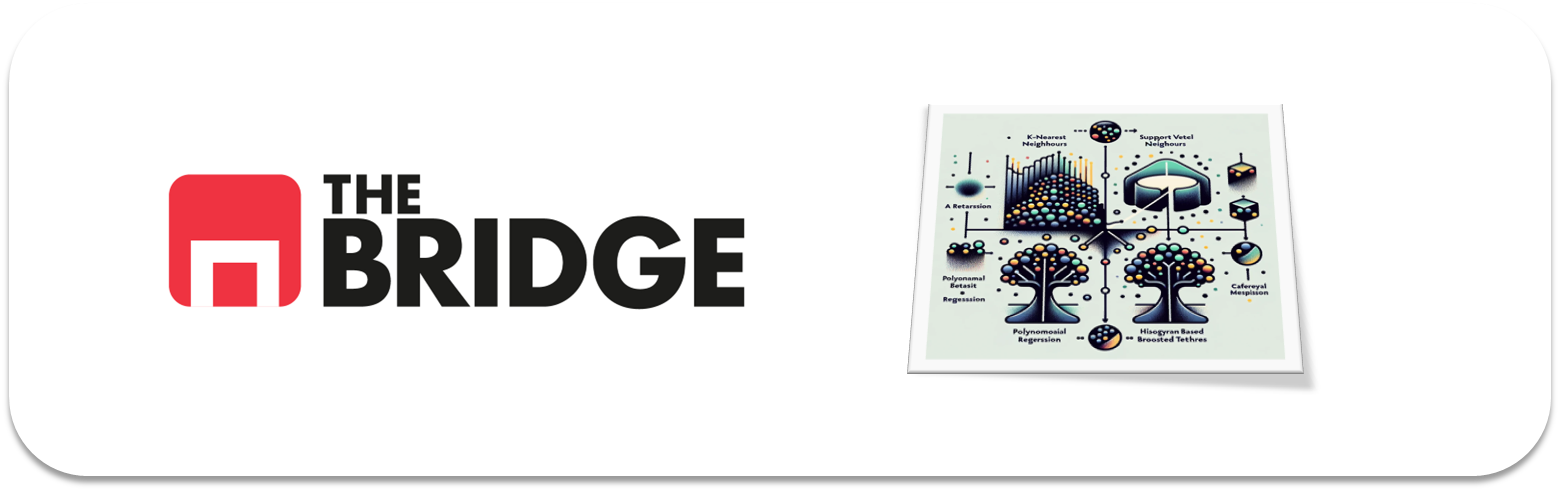

* La práctica consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [33]:
# Tratamiento de datos
import pandas as pd
import numpy as np
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, \
roc_curve, roc_auc_score, ConfusionMatrixDisplay, multilabel_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

NOTA: El dataset está limpio y sin valores faltantes.

In [3]:
df = pd.read_csv('datasets/wines_dataset.csv', sep='|')

In [4]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,35.0,178.0,0.99740,3.26,0.60,10.2,5,white
6493,8.2,0.73,0.21,1.70,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,red
6494,7.4,0.31,0.48,14.20,0.042,62.0,204.0,0.99830,3.06,0.59,9.4,5,white
6495,8.3,0.65,0.10,2.90,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,red


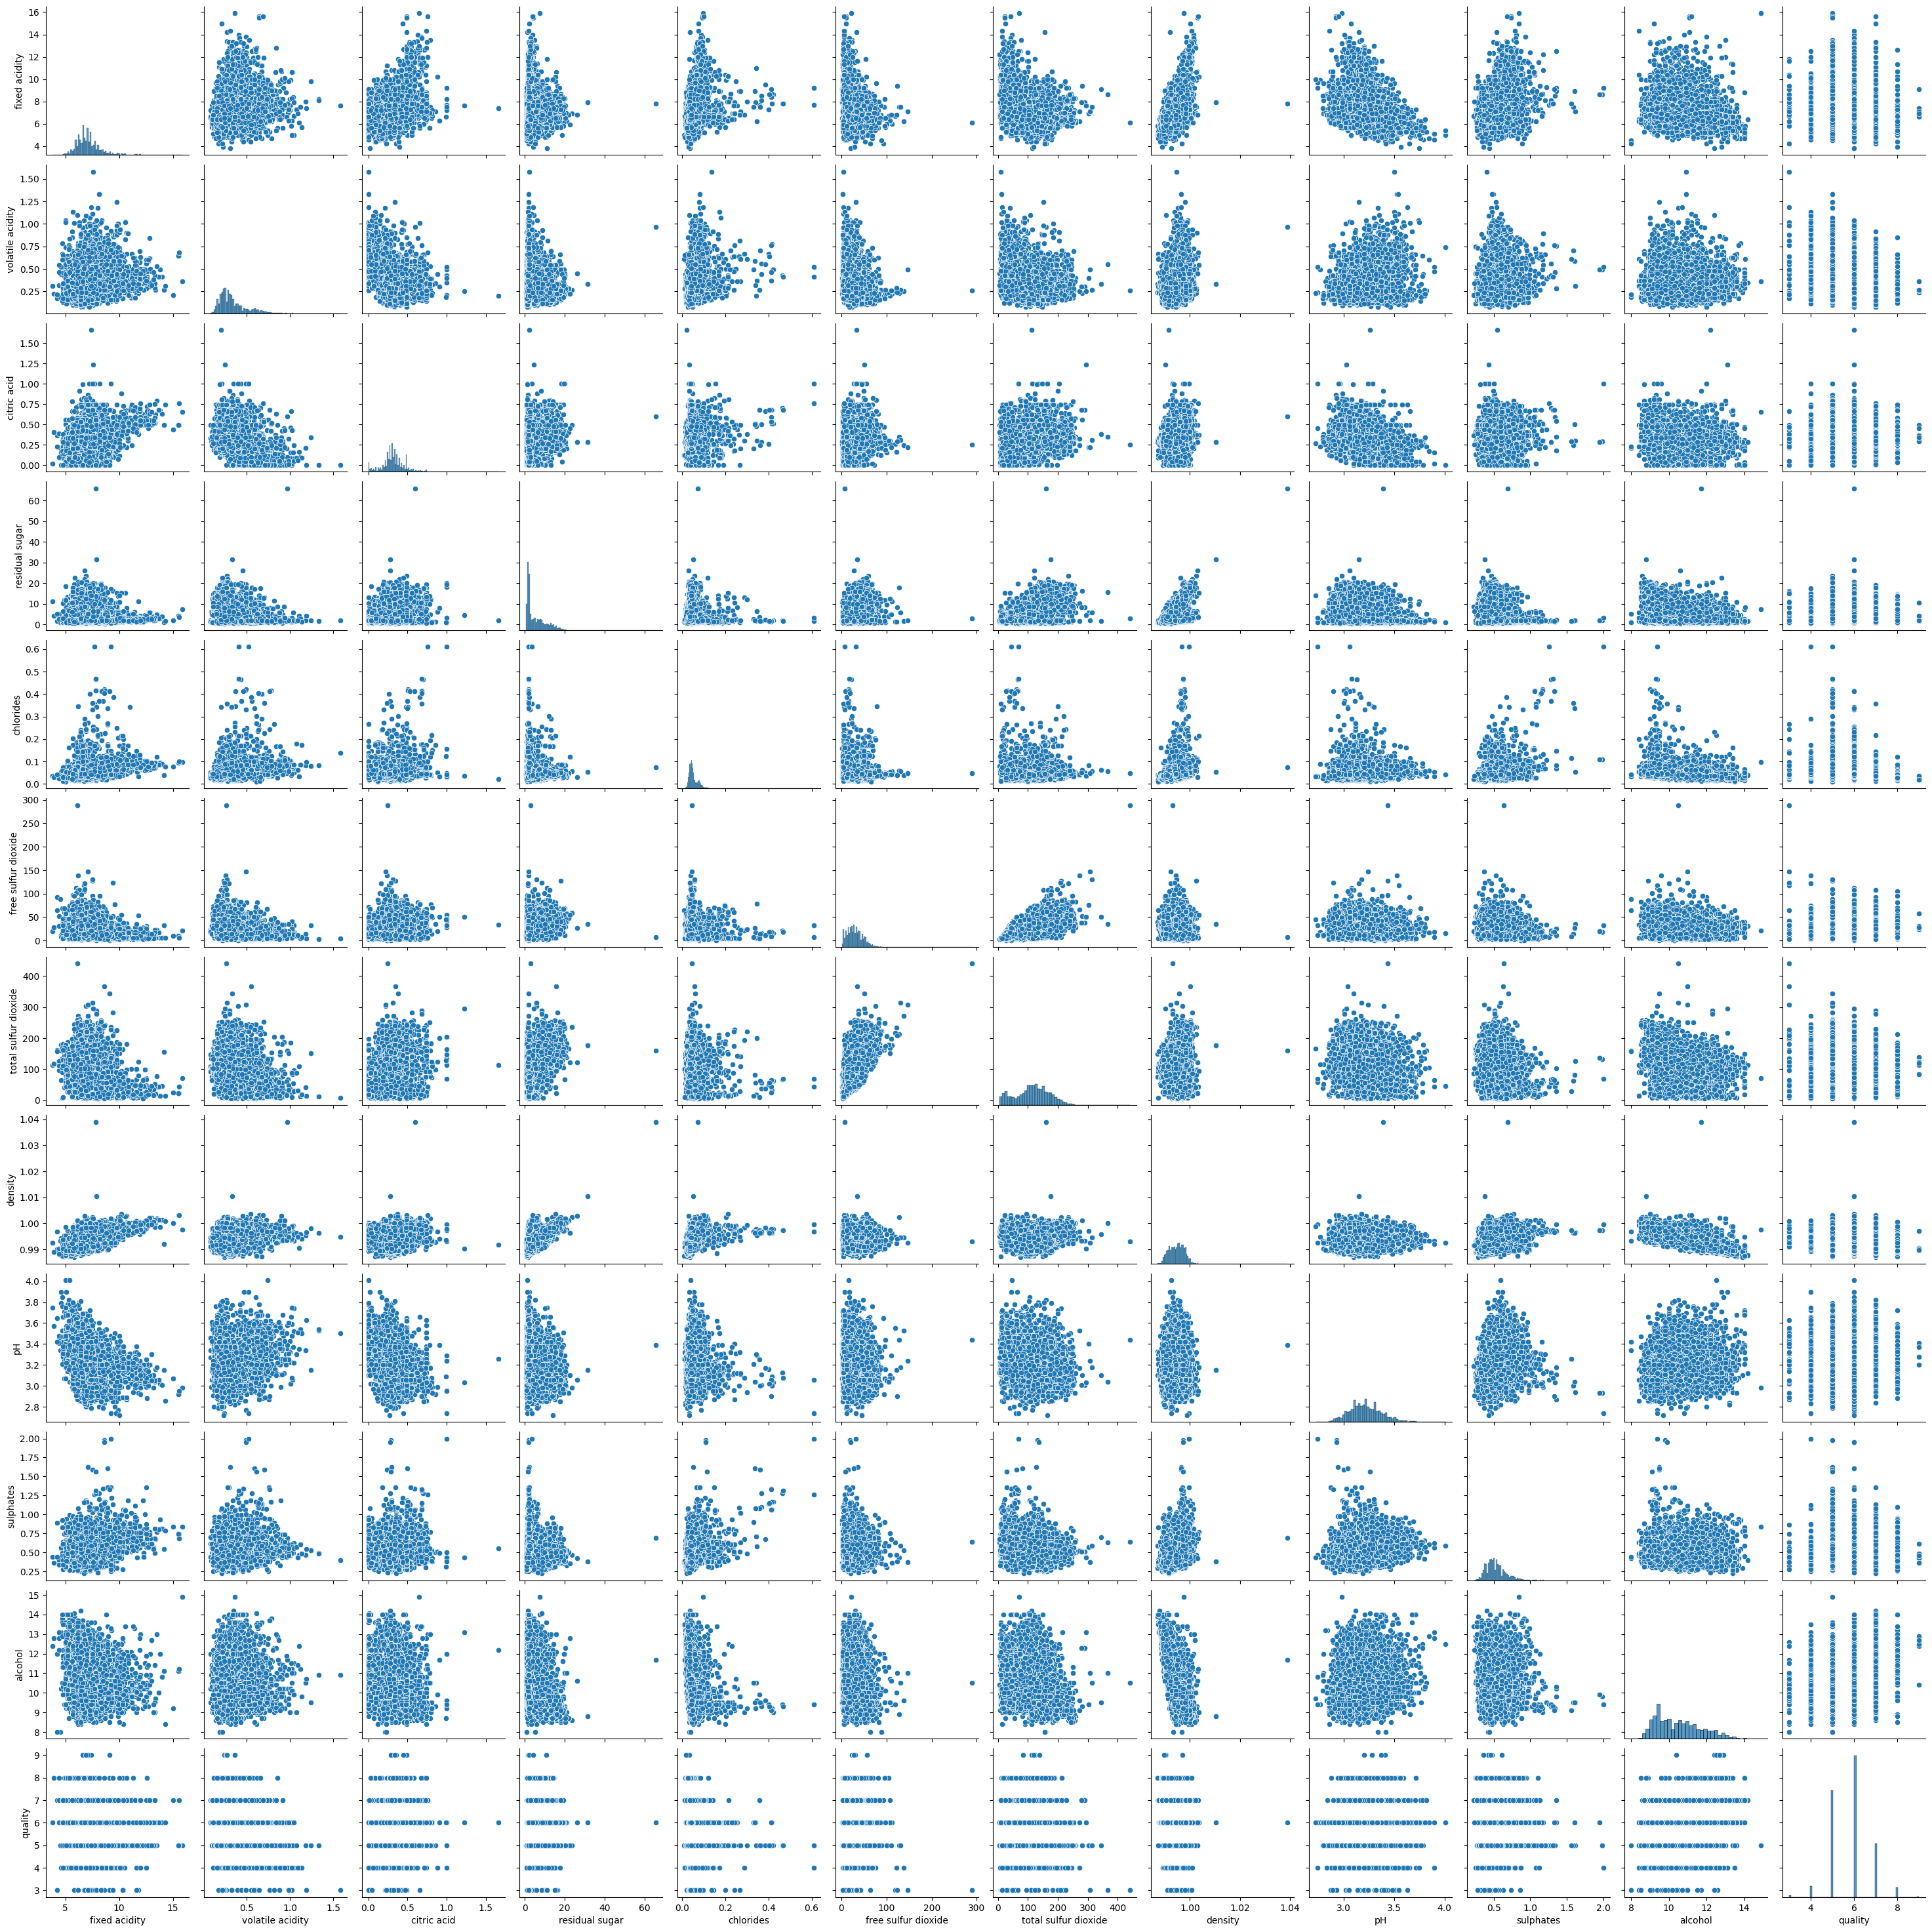

In [5]:
sns.pairplot(df)

In [6]:
def cardinalidad(df):

    columnas = df.columns

    unicos = df.nunique()

    card_100 = [(df[i].nunique()/len(df))*100 for i in df]

    tipo_dato = []
    
    for x in df.columns:
        if df[x].dtypes == '<M8[ns]':
            y = "datetime"
            tipo_dato.append(y)
        elif df[x].nunique() == 2:
            y = "boolean"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "O":
            y = "categorical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "float64":
            y = "numerical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "int64":
            y = "numerical"
            tipo_dato.append(y)
        

    cardinality = pd.DataFrame({"Columna":columnas, "Total de únicos":unicos, 
                                "Cardinalidad (%)":card_100, "Tipo de dato": tipo_dato}).set_index("Columna")
    
    return cardinality

In [8]:
cardinalidad(df)

,Total de únicos,Cardinalidad (%),Tipo de dato
Columna,,,
fixed acidity,106,1.631522,numerical
volatile acidity,187,2.878252,numerical
citric acid,89,1.369863,numerical
residual sugar,316,4.863783,numerical
chlorides,214,3.293828,numerical
free sulfur dioxide,135,2.077882,numerical
total sulfur dioxide,276,4.248115,numerical
density,998,15.360936,numerical
pH,108,1.662306,numerical


In [9]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,35.0,178.0,0.99740,3.26,0.60,10.2,5,white
6493,8.2,0.73,0.21,1.70,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,red
6494,7.4,0.31,0.48,14.20,0.042,62.0,204.0,0.99830,3.06,0.59,9.4,5,white
6495,8.3,0.65,0.10,2.90,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,red


In [12]:
df['free sulfur dioxide'] = np.log(df['free sulfur dioxide'])
df['total sulfur dioxide'] = np.log(df['total sulfur dioxide'])

In [14]:
df['class'].replace('white', '0', inplace=True)
df['class'].replace('red', '1', inplace=True)

In [15]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,4.290459,4.955827,0.99450,3.05,0.37,11.4,6,0
1,8.3,0.16,0.37,7.90,0.025,3.637586,4.672829,0.99306,2.93,0.37,11.9,6,0
2,6.8,0.18,0.38,1.40,0.038,3.555348,4.709530,0.99180,3.32,0.59,11.2,7,0
3,6.1,0.26,0.25,2.90,0.047,5.666427,6.086775,0.99314,3.44,0.64,10.5,3,0
4,7.5,0.63,0.27,2.00,0.083,2.833213,4.510860,0.99616,3.26,0.58,9.8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,3.555348,5.181784,0.99740,3.26,0.60,10.2,5,0
6493,8.2,0.73,0.21,1.70,0.074,1.609438,2.564949,0.99680,3.20,0.52,9.5,5,1
6494,7.4,0.31,0.48,14.20,0.042,4.127134,5.318120,0.99830,3.06,0.59,9.4,5,0
6495,8.3,0.65,0.10,2.90,0.089,2.833213,3.688879,0.99803,3.29,0.55,9.5,5,1


In [18]:
tosca = df.drop(columns=['alcohol', 'quality', 'class'], axis=1)
ok = df[['alcohol', 'quality', 'class']]

In [19]:
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(tosca), columns=tosca.columns)

In [20]:
ready = pd.concat([scaled, ok], axis=1)

In [21]:
ready

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,0.991020,-0.787650,-0.403514,0.800171,-0.628984,1.537879,0.548710,-0.065579,-1.048055,-1.083833,11.4,6,0
1,0.836739,-1.091373,0.353506,0.516405,-0.885900,0.603309,0.152572,-0.545828,-1.794440,-1.083833,11.9,6,0
2,-0.320370,-0.969884,0.422326,-0.849877,-0.514799,0.485587,0.203946,-0.966046,0.631312,0.394717,11.2,7,0
3,-0.860355,-0.483928,-0.472334,-0.534581,-0.257883,3.507538,2.131802,-0.519148,1.377698,0.730751,10.5,3,0
4,0.219614,1.763621,-0.334694,-0.723758,0.769781,-0.548129,-0.074151,0.488042,0.258120,0.327510,9.8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0.373895,0.305752,0.147046,0.957819,-0.000967,0.485587,0.865002,0.901590,0.258120,0.461924,10.2,5,0
6493,0.759598,2.371067,-0.747613,-0.786818,0.512865,-2.299930,-2.798020,0.701486,-0.115073,-0.075731,9.5,5,1
6494,0.142473,-0.180205,1.110526,1.840647,-0.400614,1.304083,1.055845,1.201746,-0.985856,0.394717,9.4,5,0
6495,0.836739,1.885110,-1.504633,-0.534581,0.941059,-0.548129,-1.224752,1.111699,0.444716,0.125890,9.5,5,1


### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros. El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora.

In [22]:
toclas = ready.copy()

In [23]:
X = toclas.drop(columns='quality', axis=1)
y = toclas['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

In [28]:
modelos = {
    "Logistic Regression": LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
}

# Define las métricas a usar
metricas = ["accuracy", "f1_macro", "recall_macro", "precision_macro"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train, y_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict])

resultados_df.T

,0
Logistic Regression_accuracy,0.537044
Logistic Regression_f1_macro,0.219655
Logistic Regression_recall_macro,0.218968
Logistic Regression_precision_macro,0.286101
DecisionTreeClassifier_accuracy,0.575718
DecisionTreeClassifier_f1_macro,0.334965
DecisionTreeClassifier_recall_macro,0.337419
DecisionTreeClassifier_precision_macro,0.335418
RandomForestClassifier_accuracy,0.660767
RandomForestClassifier_f1_macro,0.377857


In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [31]:
recall = recall_score(y_test, y_pred, average='macro')

In [32]:
recall

0.40663583448426327

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara los modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros. Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [34]:
toreg = df.copy()

In [35]:
X = toreg.drop(columns='alcohol', axis=1)
y = toreg['alcohol']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

In [36]:
modelos = {
    "Logistic Regression": LogisticRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
}

# Define las métricas a usar
metricas = ["accuracy", "f1_macro", "recall_macro", "precision_macro"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train, y_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict])

resultados_df.T

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\taylo\Documents\GitHub\DS_PT_09_2023\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\taylo\Documents\GitHub\DS_PT_09_2023\.venv\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\taylo\Documents\GitHub\DS_PT_09_2023\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    check_classification_targets(y)
  File "c:\Users\taylo\Documents\GitHub\DS_PT_09_2023\.venv\Lib\site-packages\sklearn\utils\multiclass.py", line 216, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
